In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import os
os.chdir(os.path.dirname(os.getcwd()))
os.getcwd()

'/Users/minseongkim/Documents/workspace/hcrot'

In [3]:
import numpy as np
from tqdm.auto import tqdm

from hcrot import layers, optim
from hcrot.dataset import *
from hcrot.utils import *

In [4]:
f = lambda s: s[-1]
with open('datasets/data.txt', 'r', encoding='utf-8') as f:
    sentences = [] 
    texts = list(filter(lambda x: len(x), f.read().split('\n')))
    for sentence in texts:
        if ',' in sentence:
            half = sentence.split(',')[0]
            sentences.append(half)
            sentences.append(half + '.')
        sentences.append(sentence)
        sentences.append(sentence[:-1])

In [5]:
len(sentences)

654

## Tokenize

In [6]:
import re
from collections import defaultdict

PUNCTUATIONS = ['?','!','@','#','$','%','&','*','(',')','-','=','+',',','.',';',':','\'']
LOWER_ALPHAS = [chr(i) for i in range(97,97+26)]
UPPER_ALPHAS = [chr(i) for i in range(65,65+26)]
NUMBERS = ['0','1','2','3','4','5','6','7','8','9']
WHITE = chr(0x0120)
SPECIAL_TOKENS = ["<eos>", "<pad>", "<unk>"]

dictionary = defaultdict(int)

for sentence in sentences:
    for i, word in enumerate(sentence.split()):
        tokenized = re.findall(r"\w+|[^\w\s]", word)
        if i != 0:
            tokenized[0] = WHITE + tokenized[0]
        for w_ in tokenized:
            dictionary[w_] += 1

vocabulary =  PUNCTUATIONS + LOWER_ALPHAS + UPPER_ALPHAS + SPECIAL_TOKENS + [WHITE] + NUMBERS
MAX_ITERATIONS = 1000
max_vocab_size = 10000
iterations = 0

def split_word(word, vocab):
    i, word_splited = 0, []
    while i < len(word):
        matched = False
        for j in range(len(word), i, -1):
            if word[i:j] in vocab:
                word_splited.append(word[i:j])
                i = j
                matched = True
                break
        if not matched:
            word_splited.append(word[i])
            i += 1
    return word_splited

In [7]:
# while iterations < MAX_ITERATIONS and len(vocabulary) < max_vocab_size:
#     pairs = defaultdict(int)
#     for word, cnt in dictionary.items():
#         tokens = split_word(word, set(vocabulary))
#         for a, b in zip(tokens[:-1],tokens[1:]):
#             pairs[a + b] += cnt
        
#     if not pairs:
#         break
    
#     best_pair = max(pairs.items(), key=lambda x: x[1])[0]
#     vocabulary.append(best_pair)
    
#     new_dictionary = defaultdict(int)
#     for word, cnt in dictionary.items():
#         tokens = split_word(word, set(vocabulary))
#         new_word = ''.join(tokens)
#         new_dictionary[new_word] += cnt
#     dictionary = new_dictionary
#     iterations += 1

# with open("notebooks/vocab.txt","w") as f:
#     for vocab in vocabulary:
#         f.write(vocab+"\n")

In [7]:
with open("notebooks/vocab.txt") as f:
    vocabulary = f.read().split("\n")

In [8]:
class BPETokenizer:
    def __init__(self, vocab: list, max_len = 52):
        self.vocab = vocab
        self.max_len = max_len
        
        self.token2ids = {token:i for i, token in enumerate(vocab)}
        self.ids2token = {i:token for token, i in self.token2ids.items()}
        
        self.white = chr(0x0120)
        self.EOS = self.token2ids["<eos>"]
        self.PAD = self.token2ids["<pad>"]
        self.UNK = self.token2ids["<unk>"]
        self.special_tokens = [self.EOS, self.PAD, self.UNK]

    def __call__(self, inputs: list):
        token_ids = self.encode(inputs)
        for i, ids in enumerate(token_ids):
            token_ids[i] = ids + [self.EOS] + [self.PAD] * (self.max_len - len(ids) - 1)
        return np.array(token_ids)

    @property
    def vocab_size(self):
        return len(self.vocab)

    def encode(self, inputs: list):
        if isinstance(inputs, str):
            inputs = [inputs]
        
        encoded = []
        for string in inputs:
            tokens = self.tokenize(string)
            ids = [self.token2ids[token] for token in tokens]
            encoded.append(ids)
        return encoded

    def decode(self, token_ids: list, skip_special_tokens: bool = False):
        decoded = []
        for tokens in token_ids:
            if not skip_special_tokens:
                tokens = [self.ids2token[token] for token in tokens]
            else:
                tokens = [self.ids2token[token] for token in tokens if token not in self.special_tokens]
            tokens = ''.join(tokens)
            decoded.append(tokens.replace(self.white, ' '))
        return decoded

    def tokenize(self, sentence: str):
        tokens = []
        for i, word in enumerate(sentence.split()):
            word = self.white + word if i != 0 else word
            tokens += self.word_tokenize(word)
        return tokens

    def word_tokenize(self, word: str):
        word = split_word(word,self.vocab)
        while True:
            i, r = 0, []
            while i < len(word):
                if i + 1 < len(word) and (word[i] + word[i+1]) in self.vocab:
                    r.append(word[i] + word[i+1])
                    i += 1
                elif word[i] in self.vocab:
                    r.append(word[i])
                else:
                    r.append("<unk>")
                i += 1
            if word == r:
                break
            word = r
        return word

tokenizer = BPETokenizer(vocab=vocabulary, max_len=100)

## Modeling

In [12]:
class GPTModel(layers.Module):
    def __init__(self, vocab_size, max_len, embed_dim, num_heads, num_layers):
        super().__init__()
        self.embed = layers.GPTEmbedding(vocab_size, embed_dim, max_len)
        self.blocks = layers.Sequential(*[layers.GPTBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.ln_f = layers.LayerNorm(embed_dim)
        self.fc_out = layers.Linear(embed_dim, vocab_size)
    
    def forward(self, x):
        x = self.embed(x)
        for mod in self.blocks:
            x = mod(x)
        x = self.ln_f(x)
        return self.fc_out(x)

## Train

### GPT

In [14]:
embed_size = 128
num_heads = 4
num_layers = 4
max_len = tokenizer.max_len
vocab_size = tokenizer.vocab_size

model = GPTModel(vocab_size=vocab_size, embed_dim=embed_size, num_heads=num_heads, num_layers=num_layers, max_len=max_len)
# model.load_state_dict(load('notebooks/gpt2.pkl'))

criterion = layers.CrossEntropyLoss(ignore_index=tokenizer.PAD)
optimizer = optim.AdamW(model, lr_rate=1e-4, betas=(0.9, 0.95))

tokenized = tokenizer(sentences)
inputs = tokenized[:, :-1]
targets = tokenized[:, 1:]

dataloader = Dataloader(inputs, targets, batch_size=4, shuffle=True)
mini_batch_len = len(dataloader)

num_epochs = 100
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    total_loss = 0
    for inputs_, targets_ in dataloader:
        bsz, seq_len = inputs_.shape
        outputs = model(inputs_)
        outputs = outputs.reshape(-1, vocab_size)
        targets_ = targets_.reshape(-1)
        loss = criterion(outputs, targets_)
        total_loss += loss.item()

        dz = criterion.backward()
        dz = dz.reshape(bsz, seq_len, -1)
        optimizer.update(dz)
    
    pbar.set_description(f'Loss: {total_loss/mini_batch_len:.5f}')
    if total_loss/mini_batch_len <= 0.001:
        break

Loss: 0.00075:  36%|███▌      | 36/100 [1:40:12<2:58:09, 167.03s/it]


In [16]:
save(model.state_dict(), 'notebooks/gpt2.pkl')

## Predict

### GPT

In [17]:
def generate_sentence(model, start_sentence, max_len):
    generated = tokenizer.encode(start_sentence)
    input_seq = np.array(generated)
    
    model.eval()
    while len(input_seq[0]) < max_len:
        logits = model(input_seq)
        next_token_logits = logits[-1, -1]

        probs = softmax(next_token_logits, dim=-1)
        # candidates = sorted([(tokenizer.decode([[token]]), round(prob,2)) for token, prob in enumerate(probs)],key=lambda x: -x[1])[:5]
        # print(candidates)

        next_token = np.argmax(probs).item()
        generated[0].append(next_token)
        if next_token == tokenizer.EOS:
            break
        input_seq = np.array(generated)
    return tokenizer.decode(generated, skip_special_tokens=False)[0]


# Great minds think alike, but they also think differently.
input_sentence = "Great minds think alike, but they also think"
print(f'greedy: {generate_sentence(model, input_sentence, max_len=max_len)}')

greedy: Great minds think alike, but they also think alike.<eos>


In [18]:
def generate_with_condition(model, start_sentence, max_len, top_k=0, top_p=1.0, temperature=1.0, repetition_penalty=1.2, no_repeat_ngram_size=3):
    def apply_temperature(logits, temperature=1.0):
        if temperature <= 0.:
            return logits
        
        return logits / temperature

    def apply_repetition_penalty(logits, generated_tokens, penalty=1.2):
        for t in set(generated_tokens.tolist()[0]):
            logits[-1, t] /= penalty
        return logits

    def ngram_blocking(logits, generated_tokens, no_repeat_ngram_size=3):
        if len(generated_tokens) < no_repeat_ngram_size - 1:
            return logits
    
        ngram = tuple(generated_tokens[-(no_repeat_ngram_size - 1):])
        blocked_tokens = []

        for i in range(len(generated_tokens) - no_repeat_ngram_size + 1):
            if tuple(generated_tokens[i:i+no_repeat_ngram_size-1]) == ngram:
                blocked_tokens.append(generated_tokens[i+no_repeat_ngram_size-1])
        
        for bt in blocked_tokens:
            logits[-1, bt] = -float("inf")
        
        return logits

    def top_k_top_p_filtering(logits, top_k=10, top_p=0.1):
        filter_value = float('-inf')
        if top_k > 0:
            indices_to_remove = logits < np.take_along_axis(logits, np.argsort(-logits,axis=-1)[:,:top_k], axis=-1)[..., -1, None]
            logits[indices_to_remove] = filter_value
        
        if top_p < 1.:
            sorted_indices = np.argsort(-logits)
            sorted_logits = -np.sort(-logits)
            
            cumulative_probs = np.cumsum(softmax(sorted_logits, dim=-1), axis=-1)
            
            sorted_indices_to_remove = cumulative_probs > top_p
            
            # shift
            sorted_indices_to_remove = np.roll(sorted_indices_to_remove, 1)
            sorted_indices_to_remove[:,0] = 0
            
            indices_to_remove = np.zeros_like(logits, dtype=bool)
            np.put_along_axis(indices_to_remove, sorted_indices, sorted_indices_to_remove, axis=-1)
            
            logits[indices_to_remove] = filter_value
            
        return logits
    
    generated = tokenizer.encode(start_sentence)
    input_seq = np.array(generated)
    
    model.eval()
    while len(input_seq[0]) < max_len:
        logits = model(input_seq)
        next_token_logits = logits[-1]
        
        next_token_logits = apply_temperature(next_token_logits, temperature)

        next_token_logits = apply_repetition_penalty(next_token_logits, input_seq, penalty=repetition_penalty)

        next_token_logits = ngram_blocking(next_token_logits, input_seq, no_repeat_ngram_size=no_repeat_ngram_size)
        
        next_token_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
        
        probs = softmax(next_token_logits, dim=-1)[-1]
        
        # candidates = sorted([(tokenizer.decode([[token]]), round(prob,2)) for token, prob in enumerate(probs)],key=lambda x: -x[1])[:5]
        # print(candidates)

        next_token = np.random.choice(np.arange(probs.shape[0]), size=1, p=probs).item()
        generated[0].append(next_token)
        if next_token == tokenizer.EOS:
            break
        input_seq = np.array(generated)
        
    return tokenizer.decode(generated, skip_special_tokens=False)[0]

# input_sentence = "Greate minds think alike, but they also think different"
input_sentence = "Greate minds think alike, but they also think"
print(f'top_k_top_p: {generate_with_condition(model, input_sentence, max_len=52, top_k=50, top_p=0.8, temperature=0., repetition_penalty=1.2, no_repeat_ngram_size=3)}')

top_k_top_p: Greate minds think alike, but they also thinkdrlyg actionness adness no sun your fa yourself thingsie-m day all strong different life weakest link shf speak louderas fa mayies.<eos>


### Visualization

In [19]:
import matplotlib.pyplot as plt

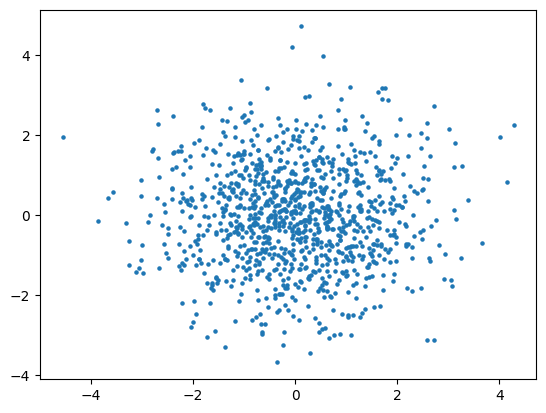

In [20]:
from sklearn.decomposition import PCA

W = model.embed.token_embed.weight
X = PCA(n_components=2).fit_transform(W)

plt.scatter(X[:,0], X[:,1], s=5)

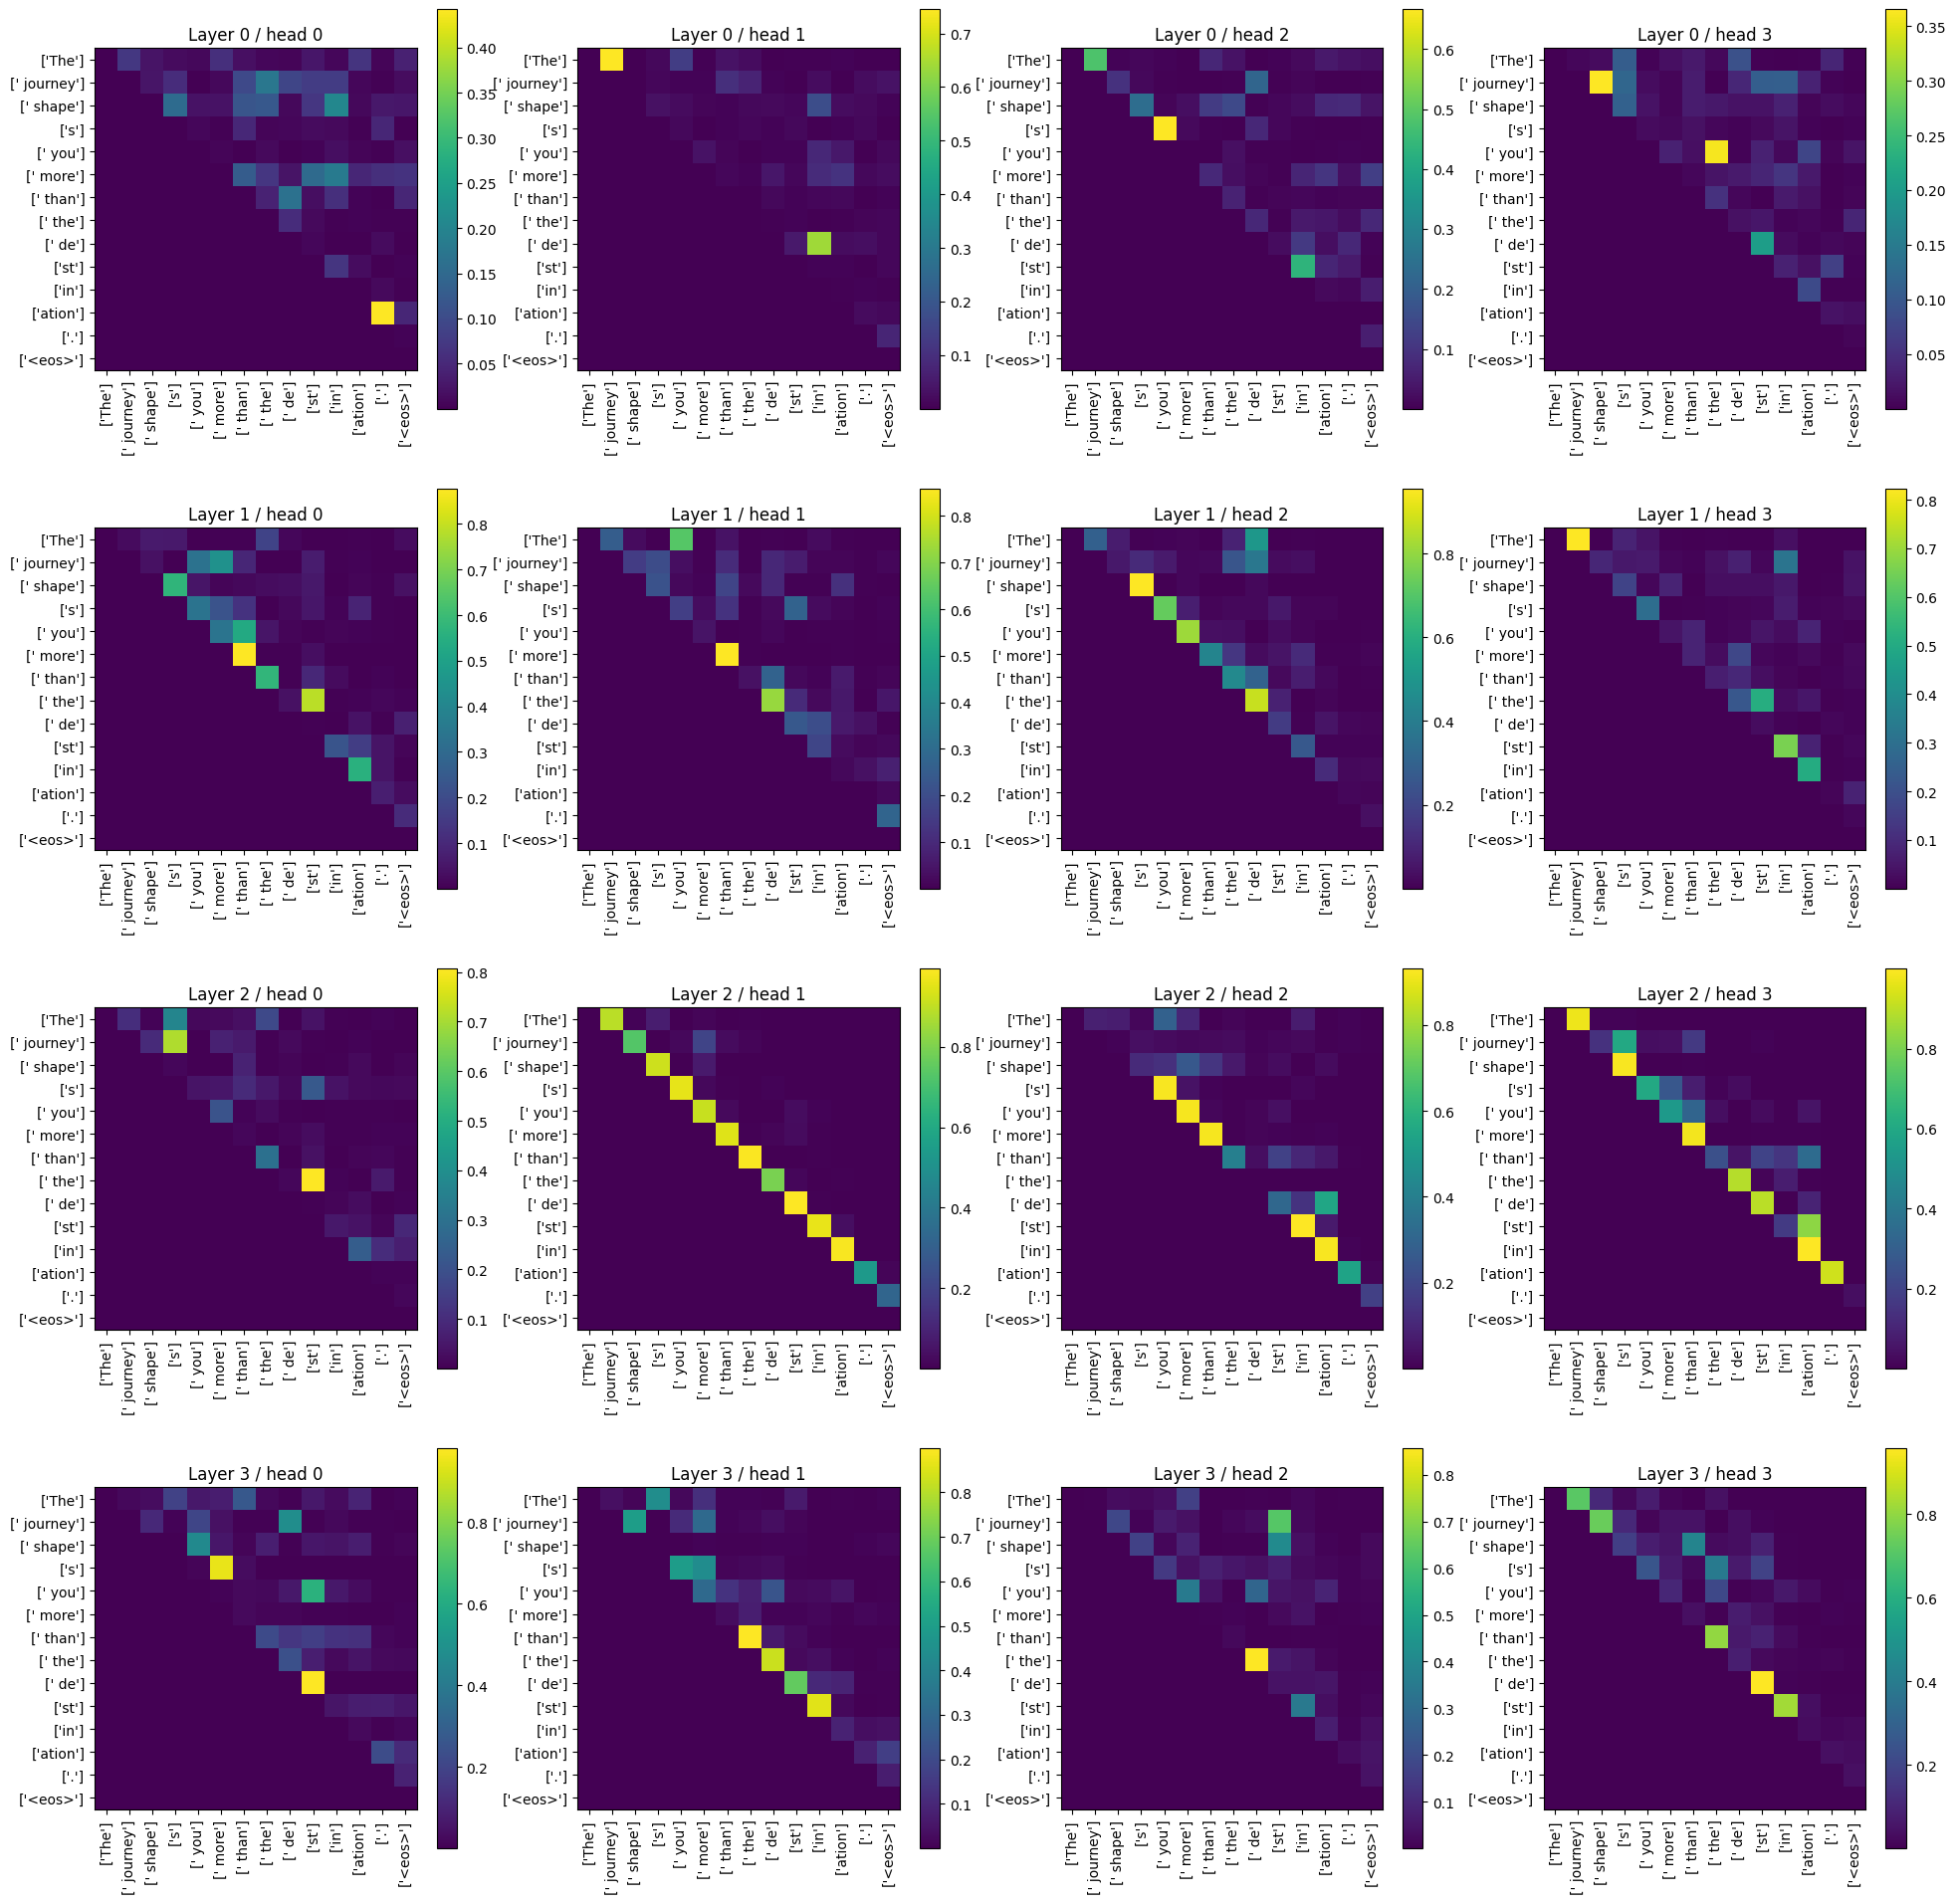

In [21]:
input_text = "The journey shapes you more than the destination."
token_ids = tokenizer(input_text)
L = token_ids.tolist()[0].index(tokenizer.PAD)
tokens = [tokenizer.decode([[token]]) for token in token_ids.tolist()[0] if token != tokenizer.PAD]

_ = model(np.array(token_ids))

fig = plt.figure(figsize=(num_layers * 6, num_heads * 6))

ids = 1
for layer in range(num_layers):
    for head in range(num_heads):
        ax = plt.subplot(num_layers, num_heads, ids)
        ax.set_title(f"Layer {layer} / head {head}")

        attn = model.blocks[layer].attn.attn_weight[0]
        plt.imshow(attn[head, :L, :L])
        plt.colorbar()
        plt.xticks(range(L), tokens, rotation=90)
        plt.yticks(range(L), tokens)
        ids += 1